In [2]:
import os
import sys

cwd0 = './config/'
sys.path.append(cwd0)

import visualID_Eng as vID
from visualID_Eng import color
vID.init(cwd0)

**Start at:** Wednesday 15 November 2023, 19:41:17  
**Hostname:** zarko (Linux)

<p style="text-align: center"><img width="800px" src="./config/svg/PytChemBanner.svg" style="margin-left:auto; margin-right:auto"/></p>


# TCCM Homework:<br>**Quality rating of red wines by logistic regression**

<div class="intro">
    
<p style="text-align: center"><img width="650px" src="./config/svg/vinho-verde-header.jpg" style="margin-left:auto; margin-right:auto" id="img_vinho_verde"></p>
<br>

1. The purpose of this project is to **predict the quality** of Portuguese Vinho Verde wines based on their **physicochemical components**. The intent is to **replace a panel of wine tasters with an artificial neural network**.

2. Two **datasets** (one for white wines and the other for red wines) are downloadable on the [UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/wine+quality). The input variables (descriptors) are
- fixed acidity
- volatile acidity
- citric acid
- residual sugar
- chlorides
- free sulfur dioxide
- total sulfur dioxide
- density
- pH
- sulphates
- alcohol

Whereas the output variable, ***i.e.* the target**, is a 0 to 10 quality score, based on sensory data

3. **Bibliography**. There are two main references:
- An [original paper](https://doi.org/10.1016/j.dss.2009.05.016): Modeling wine preferences by data mining from physicochemical properties (**2009**), by Paulo Cortez, António Cerdeira, Fernando Almeida, Telmo Matos, José Reis, *Decision Support Systems* **47**: 547-553
- A [Wine Project github repository](https://github.com/kmspitzer/final-wineproject), at the core of the [Wine Quality website](https://ucsd-winequality.herokuapp.com/). Authors explored several classifiers: K Nearest Neighbors, Decision Tree, Random Forest, Random Forest Regressor, Stochastic Gradient Descent, Support Vector Classification, Linear Support Vector Classification, AdaBoost Classifier, Gradient Boost Classifier, XGB Classifier, and obtained 69% to 95% performance, the highest being from the Random Forest Regression, Random Forest, and XGBoost models.

Some useful pieces of codes will be found on the previous website as well as on the present PytChem repository. If you analyze the ML notebooks carefully, you will see that some pieces of code such as automatic one-hot encoding etc... are available, although they might have not been used during the talktorials (see the [DS4B-Appendix.ipynb notebook](./DS4B-Appendix.ipynb) and the [tools4PytChem.py scripts](./config/tools4PytChem.py))

4. **Mandatory implementation**.
- The code will be developed in Python, in **this Jupyter notebook**, using mainly the Keras and Tensorflow ML libraries, although some ML SciKit Learn tools can also be used, if necessary.
- It will be commented both using **Markdown cells** and **Python block comments or inline comments**.
- No separate report is required, the **final present notebook** will be used both to evaluate the code and to explain the purpose of each section and how the results should be analyzed.
- Particular attention will be paid to the **organization of the notebook**: use headers, ordered or unordered list of items, tables, mathematical formulas, hyperlinks, images, ....
- As done in the [Wine Project](https://github.com/kmspitzer/final-wineproject), **data will be cleaned and prepared**. A correlation matrix will plotted. You will do that separately for white and red wines. It could be interesting - or not -  to build a database mixing red and white wines, with a 12th descriptor for the wine color.
- You will try either a **simple ANN** and a **deep learning approach**. In addition to the accuracy of each tested ANN architecture, a **confusion matrix** would be helpful to better assess their performance.
- The numerical stability of the best model will be assessed using a **5-fold cross validation**.
</div>


<div class="intro" title="Preliminary Considerations">
I strongly advise not to re-run this notebook on your local machine. Some cells are very expensive to run and it can take a lot of time. The cell below will install all packages needed to run this notebook. Some of them are quite heavy. For data preprocessing I used scikit-learn. Two linear models were built (using scikit-learn) to serve as the baseline for comparison with the Neural Network models. I decided to build neural networks in PyTorch and use skorch wrapper. Hyperparameters optimization was done using scikit-optimize for two linear models, and raytune for neural networks. SMOTE method of unbalanced sampling comes from imblearn library.
</div>

In [ ]:
# Run this cell to check if you have all the packages installed!
%pip install "numpy<1.24.0" pandas seaborn matplotlib skorch imblearn torch scikit-learn scikit-optimize "ray[tune]"

In [2]:
# Importing general packages
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option("display.width", 180)
pd.set_option('max_colwidth', 10)

In [3]:
# Reading datasets
white_wine = pd.read_csv("datasets/winequality-white.csv",delimiter=';')
red_wine = pd.read_csv("datasets/winequality-red.csv",delimiter=';')

In [6]:
white_wine[pd.isnull(white_wine).any(axis=1)].count()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [7]:
red_wine[pd.isnull(red_wine).any(axis=1)].count()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

## Dataset Exploration and Visualization
<div class="intro">
First we need to visualize features in the dataset, their types, distribution of their values, and fix potential issues, such as missing values or errors. Fortunately, this dataset is already preprocessed, so we don't have any missing values or errors. Then the features are separated from targets. Then we need to split our dataset into training, validation and test set. We can then inspect features, their distribution and correlation. The target we want to predict is score of wine quality. Discussion of the dataset and conclusions are <a href='#dataset_analysis'>here</a>
</div>

#### Feature types

In [8]:
white_wine.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [9]:
red_wine.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

All features have numerical values and our target is integer. Therefore we don't need to perform any type of encoding.

#### Dataset splitting

In [4]:
X_white = white_wine.drop("quality",axis=1)
X_red = red_wine.drop("quality",axis=1)
Y_white = white_wine[["quality"]]
Y_red = red_wine[["quality"]]
from sklearn.model_selection import train_test_split
train_ratio = 0.80
x_white_train, x_white_test, y_white_train, y_white_test = train_test_split(X_white, Y_white, test_size=1 - train_ratio,random_state=7)
x_red_train, x_red_test, y_red_train, y_red_test = train_test_split(X_red, Y_red, test_size=1 - train_ratio,random_state=7)

### Summary of the training set

#### Basic statistical analysis

In [11]:
print(x_white_train.describe())
print('\n')
print(y_white_train.describe())

       fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  free sulfur dioxide  total sulfur dioxide    density         pH  sulphates    alcohol
count  3918.0...      3918.0...         3918.0...    3918.0...       3918.0...  3918.0...            3918.0...             3918.0...  3918.0...  3918.0...  3918.0...
mean    6.851838       0.277323          0.335066     6.362864        0.045736  35.118938            137.96...              0.994009   3.186965   0.491335  10.517758
std     0.823636       0.099162          0.120757     5.100173        0.021668  16.884647            42.153704              0.003013   0.150280   0.115144   1.235696
min     3.800000       0.080000          0.000000     0.600000        0.009000   3.000000             9.000000              0.987130   2.740000   0.220000   8.000000
25%     6.300000       0.210000          0.270000     1.700000        0.036000  23.000000            108.00...              0.991712   3.090000   0.410000   9.500000
50% 

In [12]:
print(x_red_train.describe())
print('\n')
print(y_red_train.describe())

       fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  free sulfur dioxide  total sulfur dioxide    density         pH  sulphates    alcohol
count  1279.0...      1279.0...         1279.0...    1279.0...       1279.0...  1279.0...            1279.0...             1279.0...  1279.0...  1279.0...  1279.0...
mean    8.285457       0.529957          0.268014     2.550938        0.088536  16.030102            46.970289              0.996759   3.312447   0.658210  10.399453
std     1.730476       0.177191          0.193631     1.435357        0.050362  10.635871            33.239803              0.001885   0.156295   0.173016   1.055490
min     4.600000       0.120000          0.000000     1.200000        0.012000   1.000000             6.000000              0.990200   2.740000   0.330000   8.400000
25%     7.100000       0.400000          0.090000     1.900000        0.070000   7.000000            22.000000              0.995600   3.210000   0.550000   9.500000
50% 

#### Random sample from each dataset

In [13]:
print(x_white_train.sample(10))
print('\n')
print(y_white_train.sample(10))

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  sulphates    alcohol
3880        6.0           0.28              0.24        17.80           0.047       42.0                111.0             0.99896  3.10       0.45   8.900000
3965        7.3           0.38              0.23         6.50           0.050       18.0                102.0             0.99304  3.10       0.55  11.200000
4372        7.1           0.23              0.23         3.50           0.038       23.0                112.0             0.99157  3.05       0.37  11.366667
3172        6.7           0.33              0.36         6.60           0.042       34.0                116.0             0.99123  2.97       0.31  12.200000
2297        6.5           0.29              0.42        10.60           0.042       66.0                202.0             0.99674  3.24       0.53   9.500000
271         5.2           0.60              0.07    

In [14]:
print(x_red_train.sample(10))
print('\n')
print(y_red_train.sample(10))

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  alcohol
1050        7.1          0.430              0.17         1.80           0.082       27.0                 51.0             0.99634  3.49       0.64     10.4
771         9.4          0.685              0.26         2.40           0.082       23.0                143.0             0.99780  3.28       0.55      9.4
1263        8.2          0.780              0.00         2.20           0.089       13.0                 26.0             0.99780  3.37       0.46      9.6
774         7.9          0.400              0.30         1.80           0.157        2.0                 45.0             0.99727  3.31       0.91      9.5
958         6.4          0.570              0.12         2.30           0.120       25.0                 36.0             0.99519  3.47       0.71     11.3
1300        5.2          0.645              0.00         2.15   

#### Pairplot of features

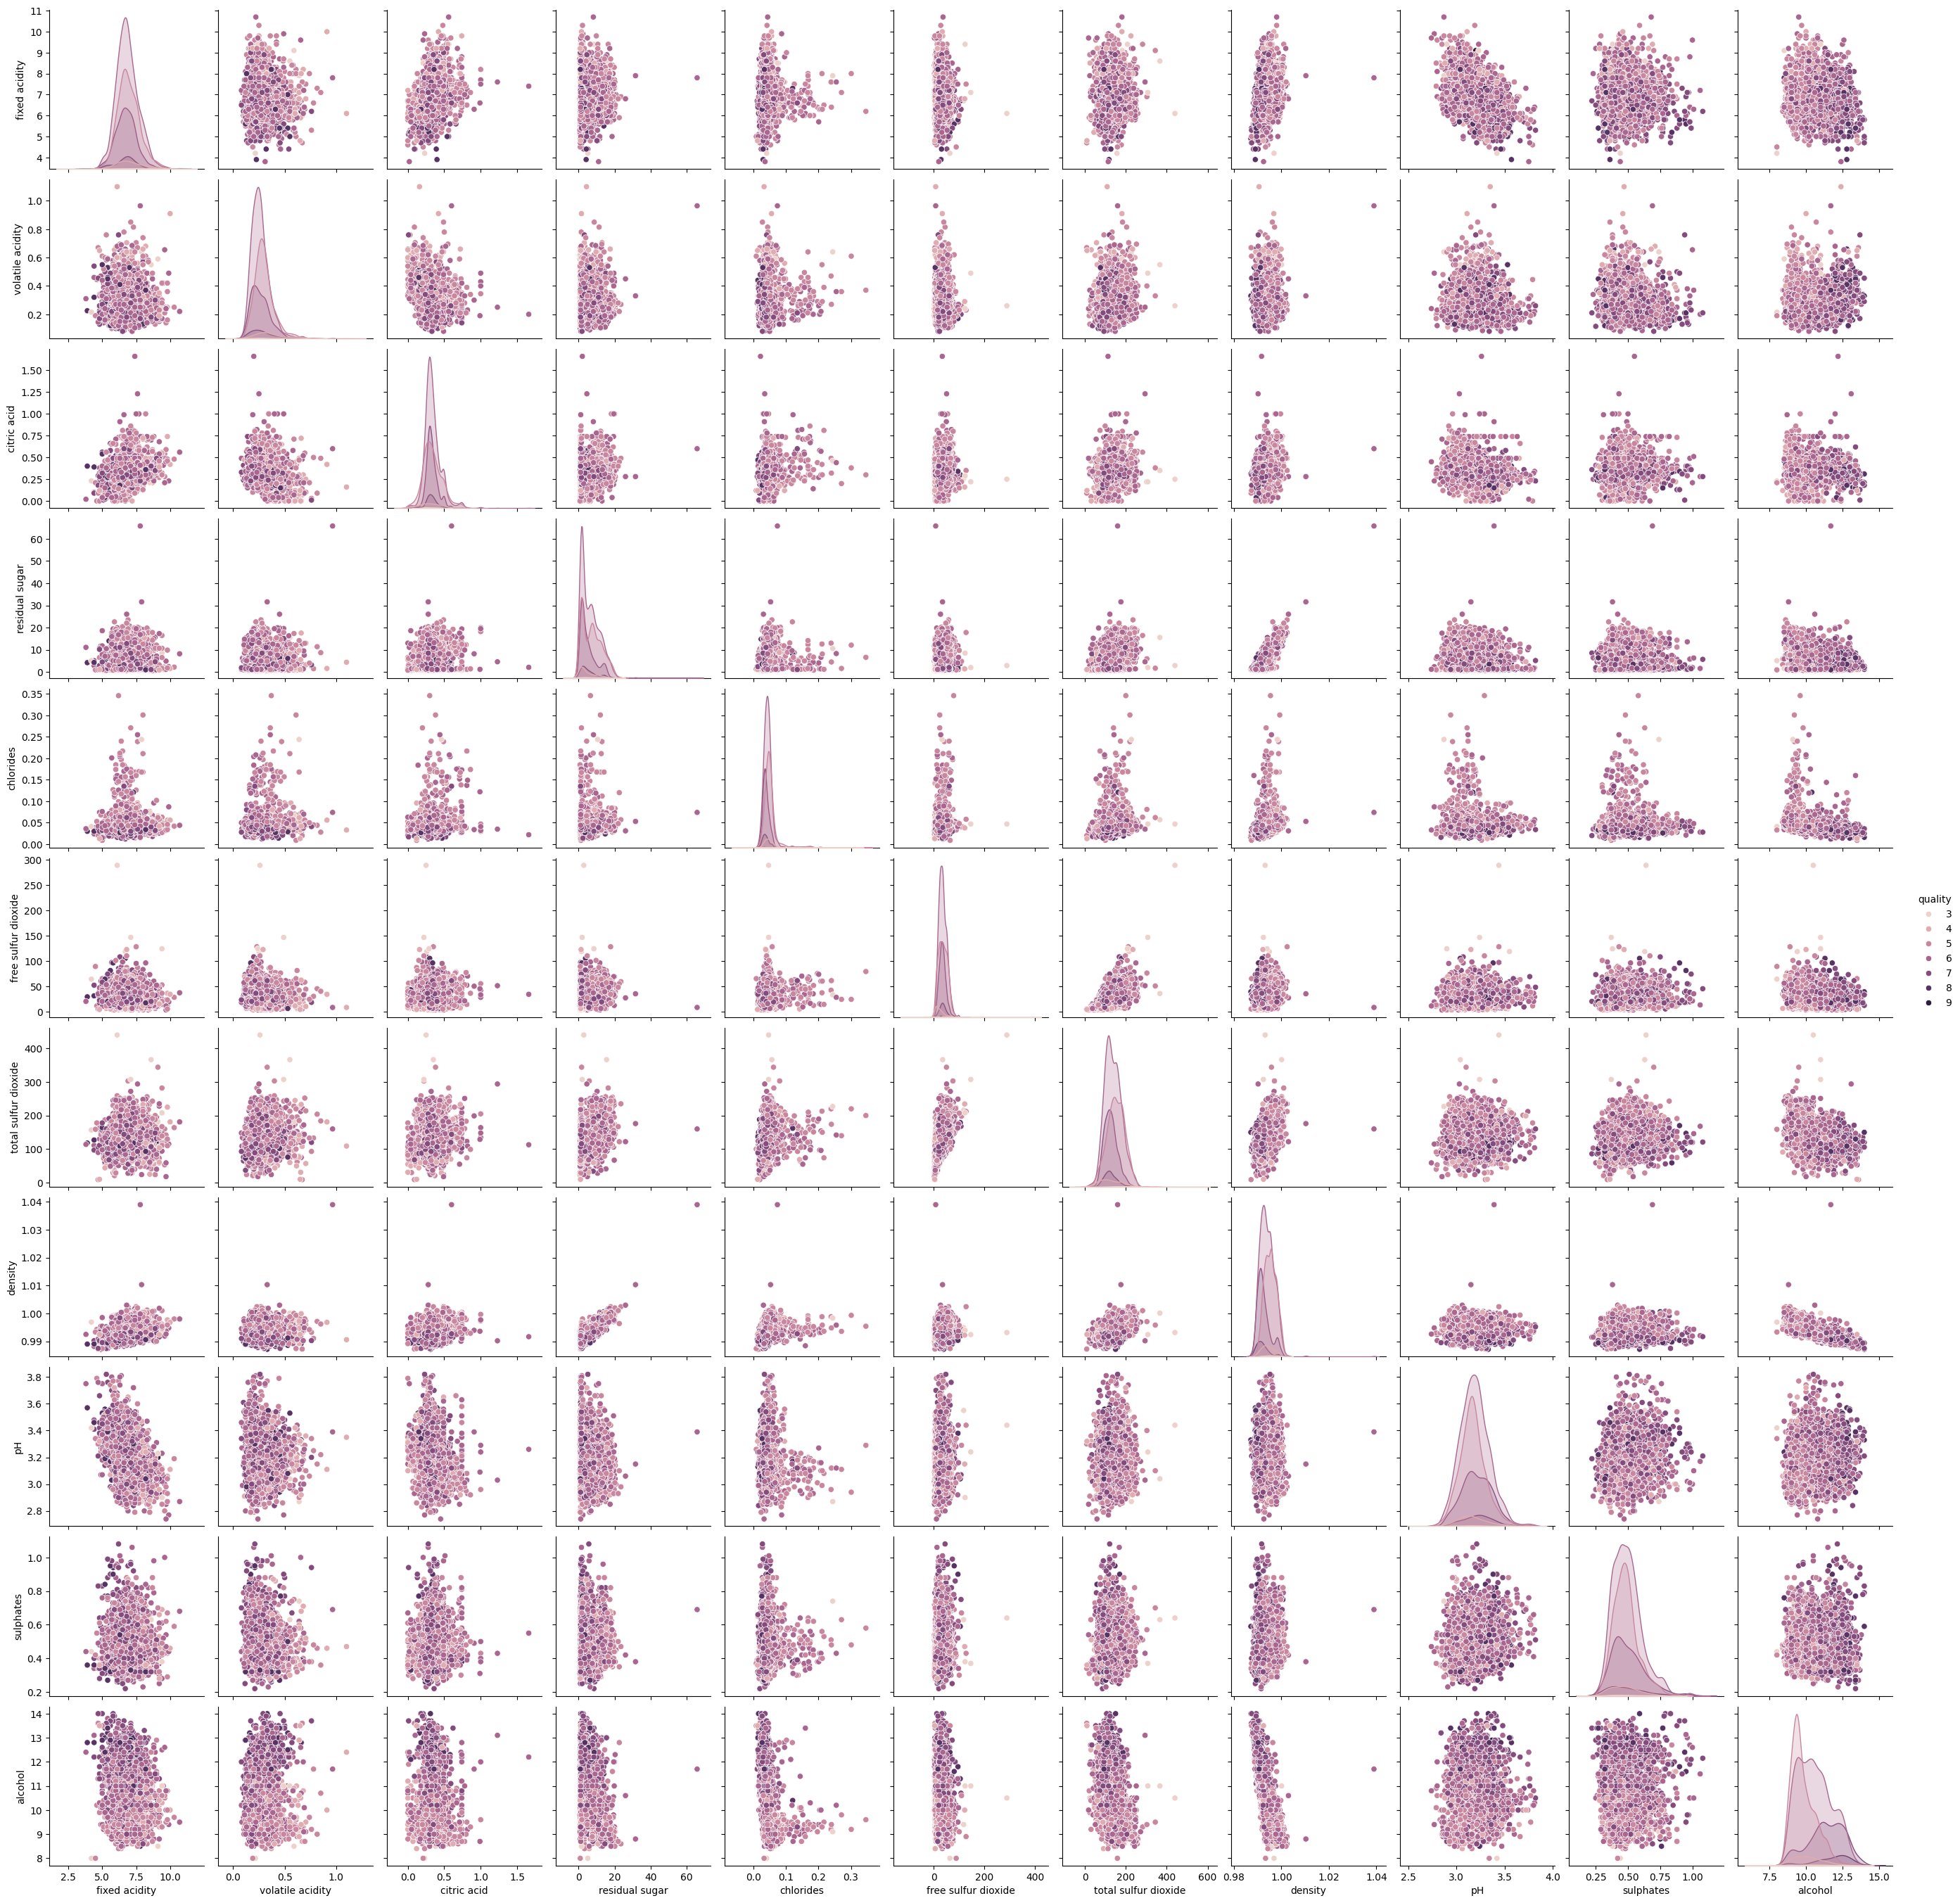

In [15]:
sns.pairplot(data=x_white_train.join(y_white_train), hue="quality");

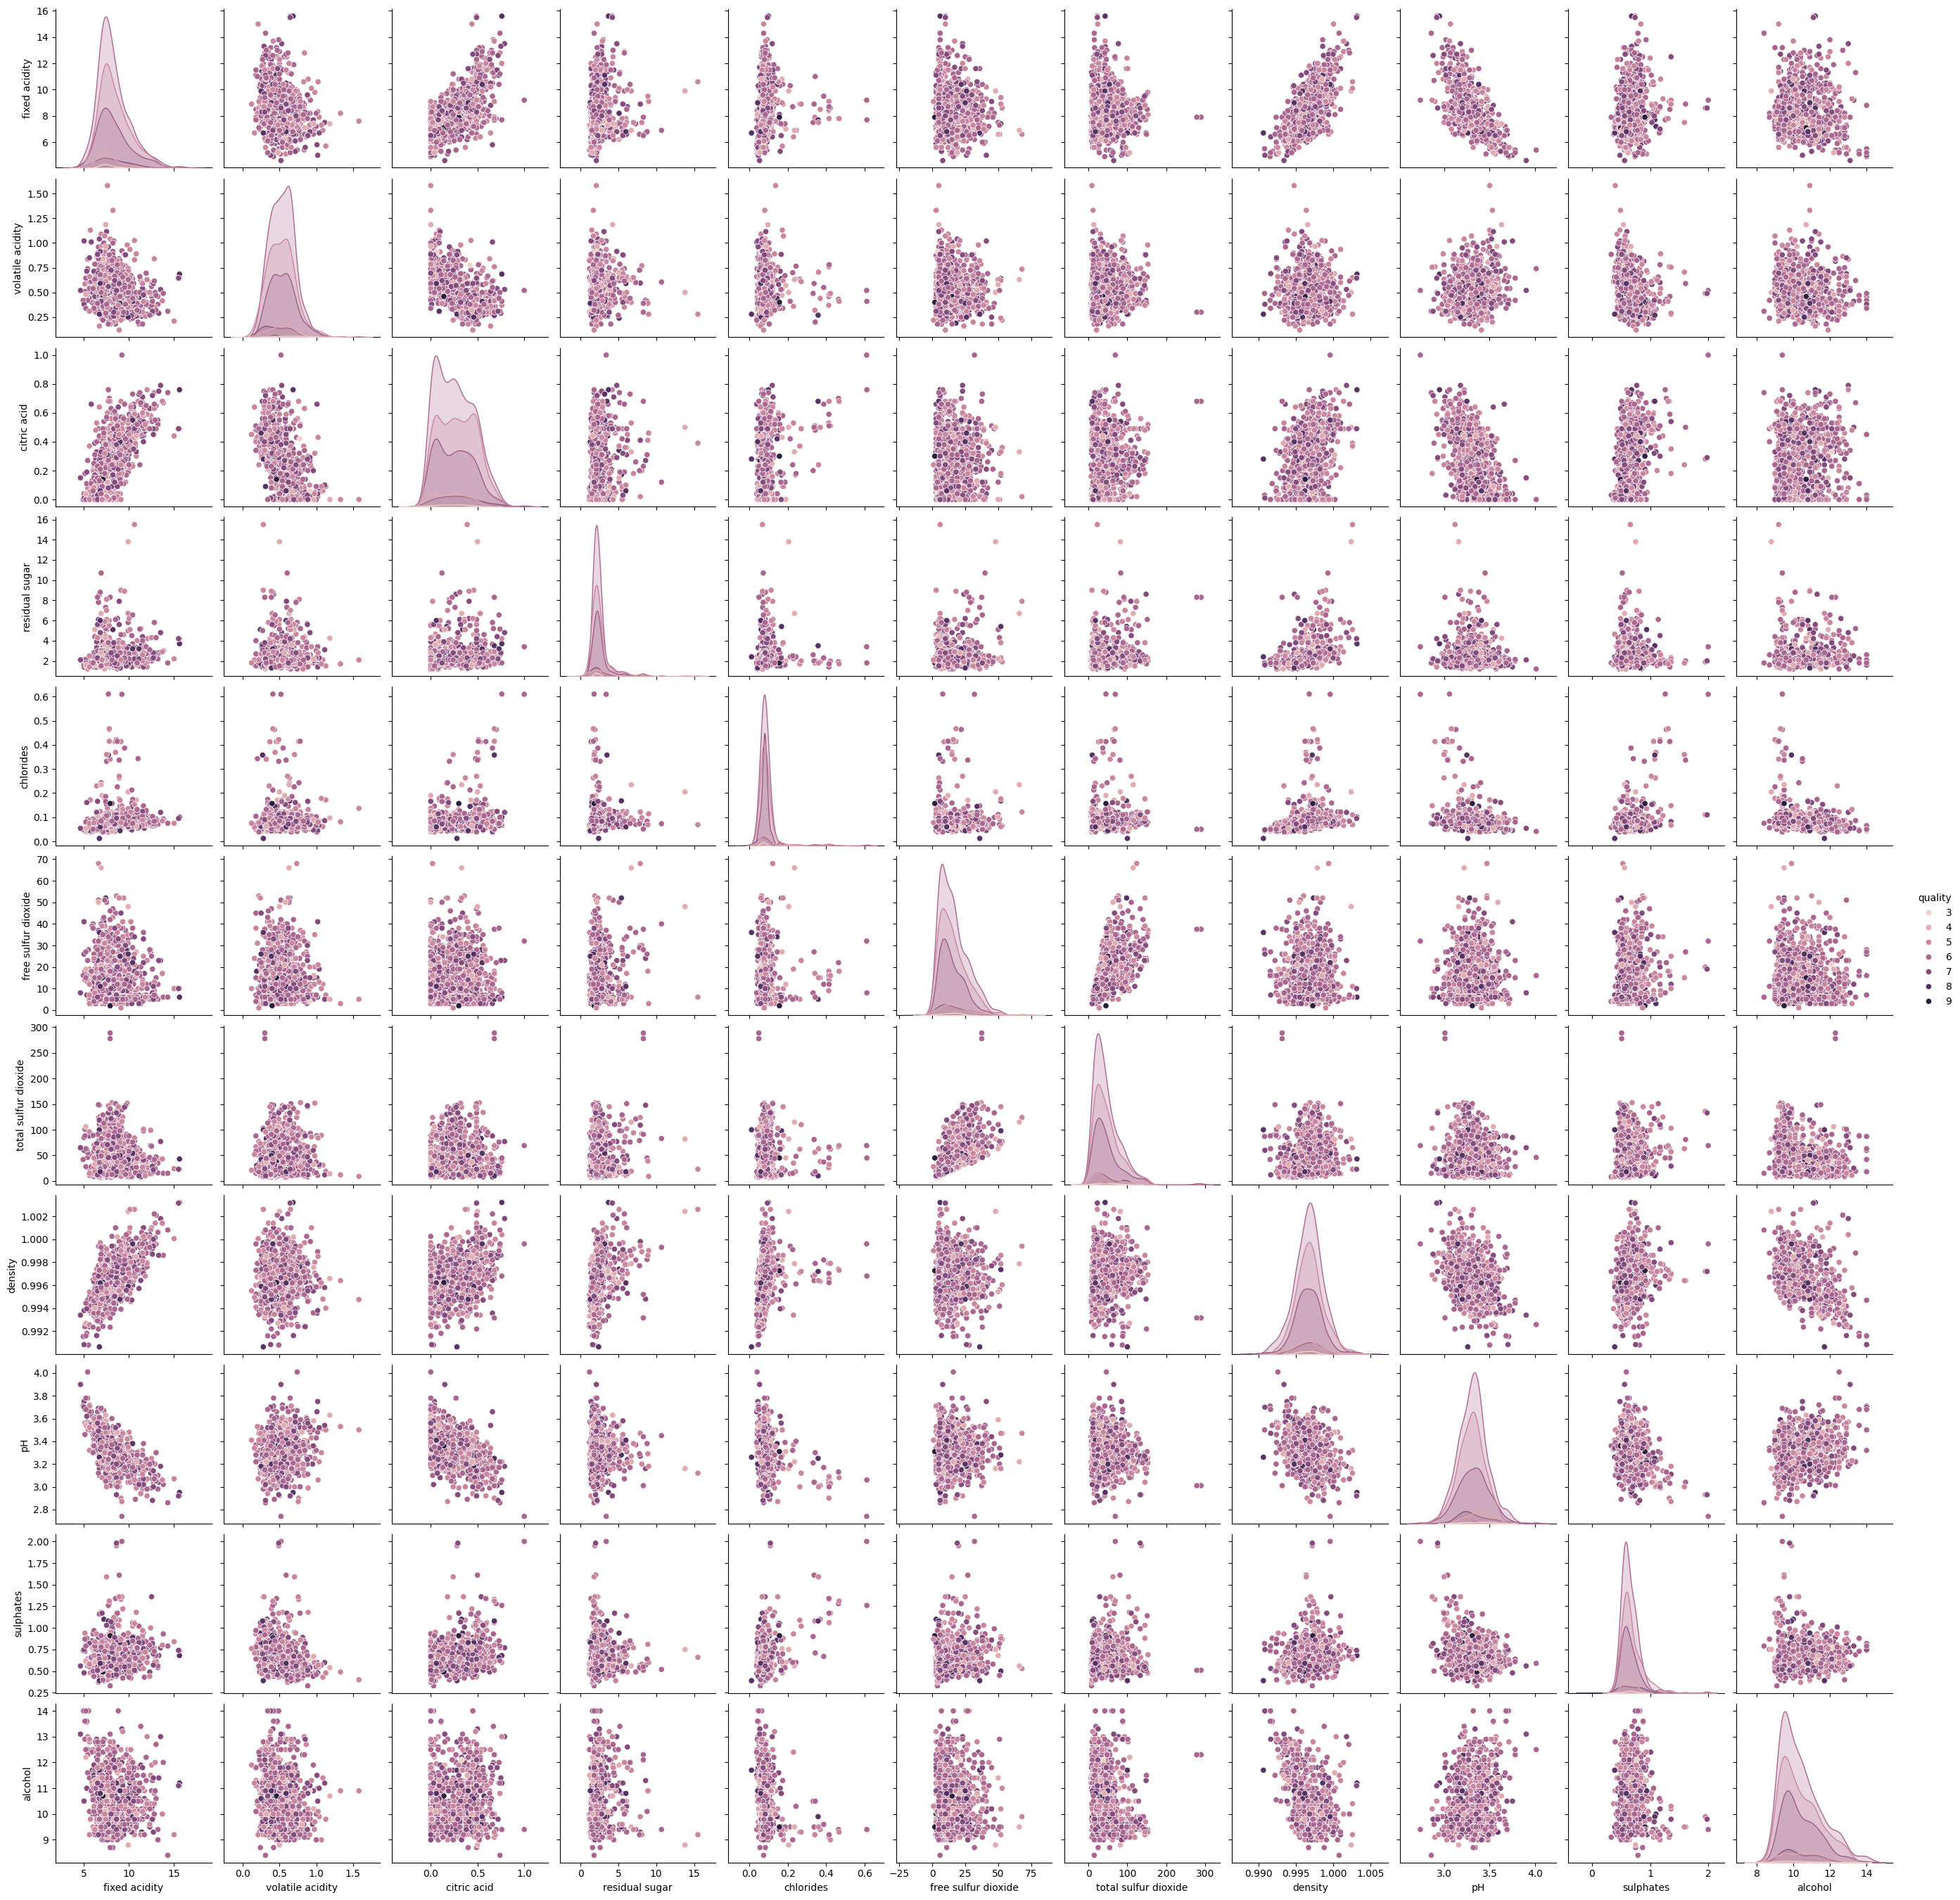

In [16]:
sns.pairplot(data=x_red_train.join(y_white_train), hue="quality");

#### Features and target distributions

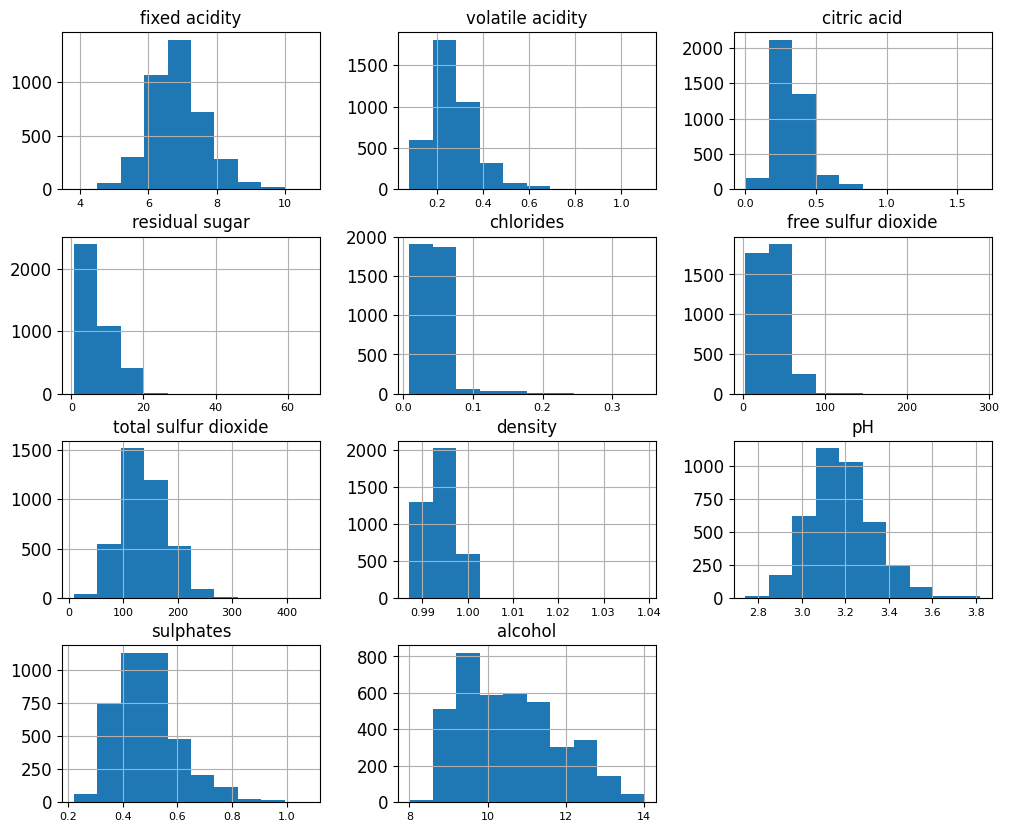

In [17]:
x_white_train.hist(figsize=(12,10),xlabelsize=8,ylabelsize=12);

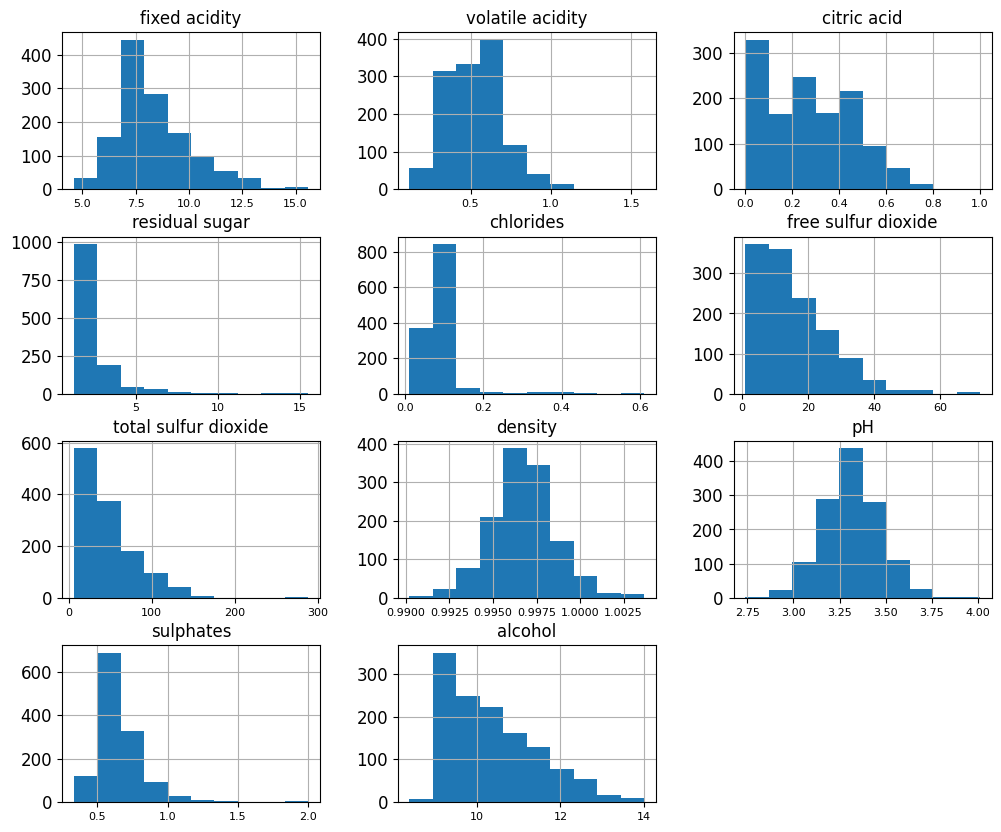

In [18]:
x_red_train.hist(figsize=(12,10),xlabelsize=8,ylabelsize=12,);

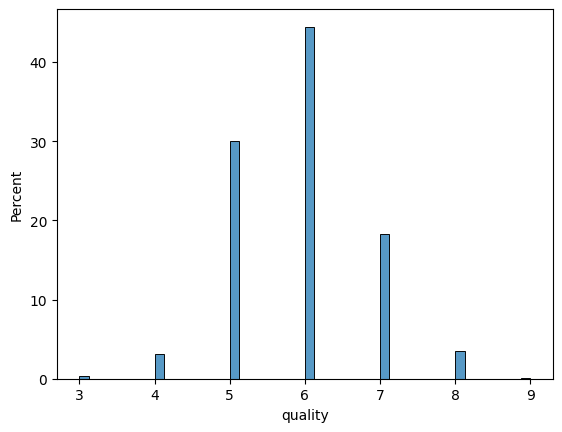

In [19]:
sns.histplot(y_white_train,stat ="percent");
target_distribution_white = y_white_train.value_counts()

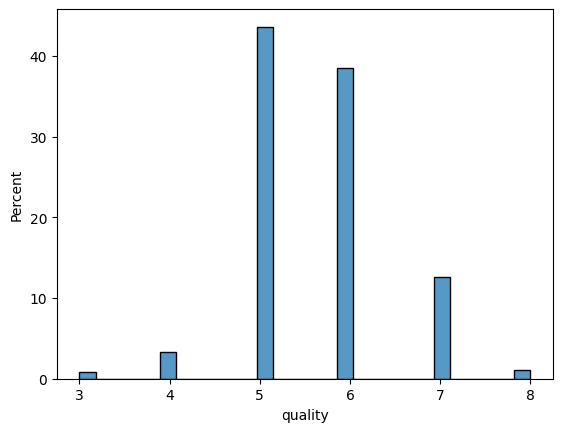

In [20]:
sns.histplot(y_red_train,stat ="percent");
target_distribution_red = y_red_train.value_counts()

#### Check for outliers

In [21]:
q_low = x_white_train.quantile(0.0005)
q_up = x_white_train.quantile(0.9995)
outliers = x_white_train[((x_white_train < q_low) | (x_white_train > q_up)).any(axis=1)]
print(outliers)
print(y_white_train.loc[outliers.index])

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  alcohol
3244        6.7          0.210              0.36         8.55           0.020       20.0                 86.0             0.99146  3.19       0.22    13.40
1373       10.7          0.220              0.56         8.20           0.044       37.0                181.0             0.99800  2.87       0.68     9.50
2945        4.9          0.330              0.31         1.20           0.016       39.0                150.0             0.98713  3.33       0.59    14.00
745         7.4          0.200              1.66         2.10           0.022       34.0                113.0             0.99165  3.26       0.55    12.20
3284        8.0          0.340              0.25         6.40           0.035       38.0                103.0             0.99148  2.91       0.23    12.20
1255        6.4          0.220              0.34         1.80   

In [22]:
q_low = x_red_train.quantile(0.0005)
q_up = x_red_train.quantile(0.9995)
outliers = x_red_train[((x_red_train < q_low) | (x_red_train > q_up)).any(axis=1)]
print(outliers)
print(y_red_train.loc[outliers.index])

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  alcohol
151         9.2          0.520              1.00          3.4           0.610       32.0                 69.0             0.99960  2.74       2.00      9.4
170         7.9          0.885              0.03          1.8           0.058        4.0                  8.0             0.99720  3.36       0.33      9.1
1316        5.4          0.740              0.00          1.2           0.041       16.0                 46.0             0.99258  4.01       0.59     12.5
1114        5.0          0.400              0.50          4.3           0.046       29.0                 80.0             0.99020  3.49       0.66     13.6
1081        7.9          0.300              0.68          8.3           0.050       37.5                289.0             0.99316  3.01       0.51     12.3
480        10.6          0.280              0.39         15.5   

#### Correlation Matrix

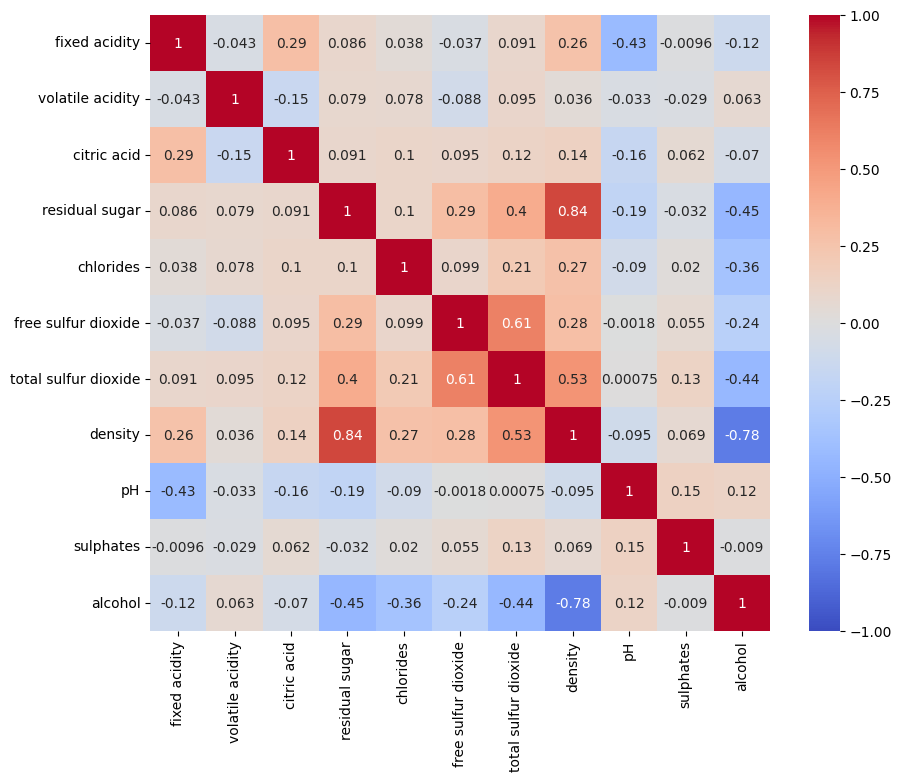

In [23]:
plt.figure(figsize = (10,8))
sns.heatmap(x_white_train.corr(numeric_only=True), vmin = -1, vmax = +1, annot = True, cmap='coolwarm');

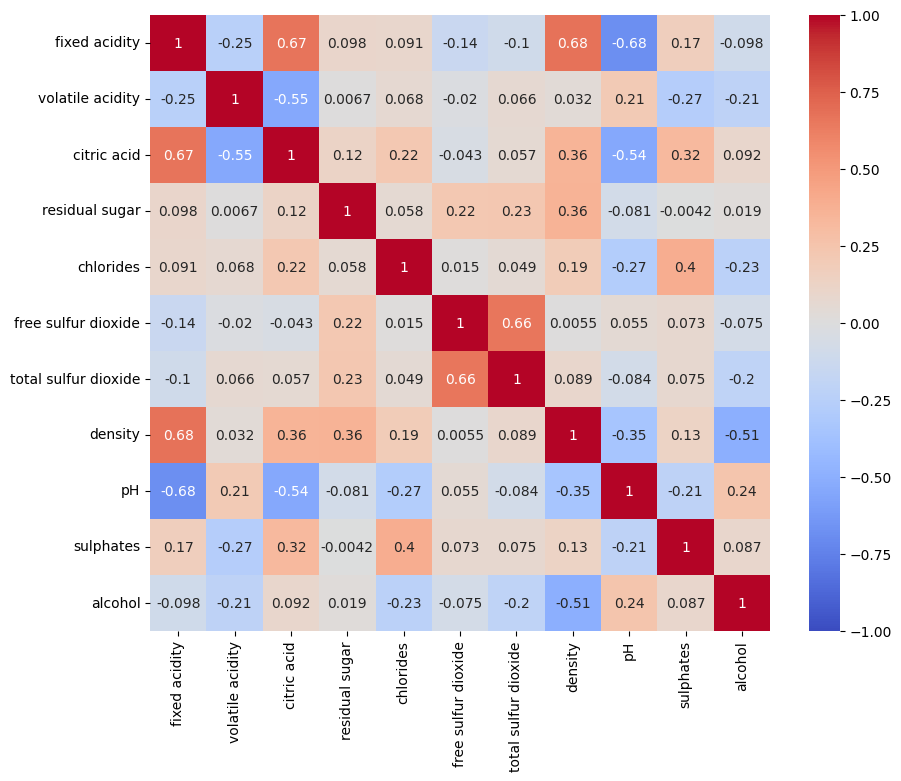

In [24]:
plt.figure(figsize = (10,8))
sns.heatmap(x_red_train.corr(numeric_only=True), vmin = -1, vmax = +1, annot = True, cmap='coolwarm');

## Dataset Analysis <a id='dataset_analysis'></a>

<div class="rqT" title="Observations">

1. The range of values features take is different for different features. Therefore, standardization of feature values must be performed.

2. We can spot certain outlayers in pairplot graph. However, those can't be just discarder, as the analysis showed that most of them are from the underrepresnted quality scores.

3. Wines of very good or very bad quality are not sufficiently represented in the dataset. There are very little wines with quality smaller than 4 or greater than 7. There are no red wines with quality higher than 8!

4. Features are generally not correlated, with one important exception for white wines: density is highly 
correlated with residual sugar and alcohol features.

</div>

### Conclusions and decisions about models
<div class="intro">

1. Dataset will be augmented using  <a href="https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html"> SMOTE </a> technique for imbalanced datasets.
2. Outliers will not be removed, as many of them belond to the underrepresented class.
3. The feature selection will be done using backwards sequential feature selector.
4. Standardization will be performed as the last step before training the model. Robust scaler will be used as it's more robust towards features that have outliers.
</div>

<div class="rqT" title="Discussing choice of models">
Our target is the quality score, an integer from 0-10. This is a problem of ordinal classification. The simplest approach would be to use any multi-label classification algorithm, such as multinomial logistic regression (also known as softmax regression) with cross-entropy as the loss function. However, this doesn't take into account order of labels. For instance, missclassifying wine of quality 8 as 1 is penalized the same was as missclassifiying it as 6. However, we would like to punish more the mistakes that are further away from the true value. Therefore, the imporeved model would use regression with mean square error as the loss function. The prediction would then be computed in a separate step, rounding output of the model to the nearest integer. The only downside of this approach is that we might get the score outside of the 0-10 interval. I will test two linear models and two neural networks
</div>

</div class="rqT" title="Models">

1. Two linear models, implemented in sckit-learn:
* Linear Logistic Regressor
* Linear Regressor
2. Two ANN models implemented in PyTorch:
* Neural Net Classifier
* Neural Net Regeressor

The first two models will be used as a baseline to compare other two models.Hyperparameters for all models will be optimized using 5-fold cross validation. Finally, Each model will be evaluated on the test set. Accuracy and confusion matrices will be calculated.
</div>

## Bulding models

In [1]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import RobustScaler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import ConfusionMatrixDisplay, balanced_accuracy_score, accuracy_score, confusion_matrix
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from ray.tune.sklearn import TuneGridSearchCV
from ray.tune.sklearn import TuneSearchCV

### Linear Ridge Regression for ordinal classification
For linear regression model, I opted for Ridge model. It's relatively simple model with only one regularization parameters that punishes the size of coefficient in linear regression.

In [27]:

from sklearn.linear_model import Ridge
# Modifying regression so it can compute integer wine quality score
class OrdinalRegressionClassifier(Ridge):
    def decision_function(self,X):
        return np.round(super().predict(X))
class smote(SMOTE):
    def __init__(self,y,sam=0,random_state=7,k_neighbors=5):
        self.sam = sam
        self.y = y
        dist = y.groupby("quality")["quality"].count()
        n_max_class = np.max(dist)
        target_distribution = {i : int(dist[i] + (n_max_class - dist[i])*sam) for i in y["quality"].unique()}
        super(smote,self).__init__(sampling_strategy=target_distribution,random_state=random_state,k_neighbors=k_neighbors)
      
  
#dist = y_red_train.groupby("quality")["quality"].count()
#n_max_class = np.max(dist)
#target_distribution = {i : dist[i] + (n_max_class - dist[i])*0.5 for i in y_red_train["quality"].unique()}
aug = ada(y_red_train,random_state=7,k_neighbors = 5,sam=0.4)

new = aug.fit_resample(x_red_train,y_red_train)
print(type(new))
print(new[1].groupby("quality")["quality"].count())

<class 'tuple'>
quality
3    229
4    249
5    558
6    518
7    320
8    231
Name: quality, dtype: int64


In [48]:
pipe1 = Pipeline([("scaler",RobustScaler()),
                ("data_augmentation",ADASYN(random_state=7,n_neighbors=3)),
                ("regressor",OrdinalRegressionClassifier(random_state=7,)),
                 ])
hiperparam_opt1_white = GridSearchCV(
    pipe1, param_grid=param_grid, scoring='neg_mean_squared_error',
)

hiperparam_opt1_white.fit(x_red_train, y_red_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('data_augmentation',
                                        ADASYN(n_neighbors=3, random_state=7)),
                                       ('regressor',
                                        OrdinalRegressionClassifier(random_state=7))]),
             param_grid=[{'data_augmentation': ['passthrough',
                                                ADASYN(n_neighbors=4,
                                                       random_state=7,
                                                       sampling_strategy='minority')],
                          'regressor__alpha': [0.1, 1, 10.0, 100.0, 1000.0]}],
             scoring='neg_mean_squared_error')

In [49]:
hiperparam_opt1_white.cv_results_

{'mean_fit_time': array([0.00622811, 0.0046308 , 0.00460892, 0.00398526, 0.0039319 ,
        0.01447568, 0.04181552, 0.06533194, 0.06891232, 0.07129169]),
 'std_fit_time': array([0.00297009, 0.00041473, 0.00061801, 0.00038823, 0.00029688,
        0.00102909, 0.02159617, 0.00482957, 0.01110267, 0.01582962]),
 'mean_score_time': array([0.00150318, 0.00147376, 0.00128894, 0.00106359, 0.00101027,
        0.00169315, 0.00167165, 0.00190272, 0.00190454, 0.00199423]),
 'std_score_time': array([6.39266084e-04, 2.10876272e-04, 4.11699816e-04, 1.96076518e-04,
        1.33590217e-04, 7.54053704e-05, 7.64363569e-05, 6.73469988e-05,
        1.02177358e-04, 2.69490062e-04]),
 'param_data_augmentation': masked_array(data=['passthrough', 'passthrough', 'passthrough',
                    'passthrough', 'passthrough',
                    ADASYN(n_neighbors=4, random_state=7, sampling_strategy='minority'),
                    ADASYN(n_neighbors=4, random_state=7, sampling_strategy='minority'),
          

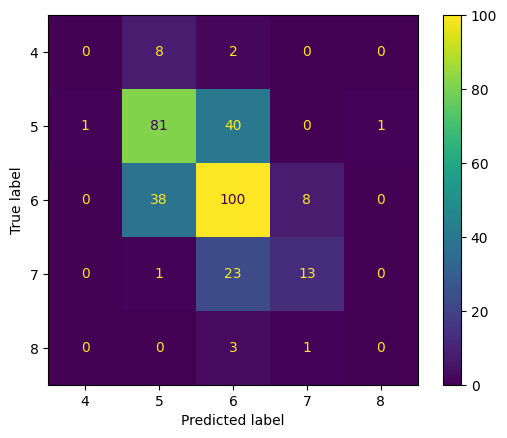

In [50]:
Y_predict1_white = hiperparam_opt1_white.decision_function(x_red_test)
ConfusionMatrixDisplay.from_predictions(y_red_test,Y_predict1_white,labels=[4,5,6,7,8]);

In [ ]:
print(balanced_accuracy_score(y_red_test,Y_predict1_white))
print(accuracy_score(y_red_test,Y_predict1_white))

### Linear logistic regression for ordinal classification

In [ ]:
from sklearn.linear_model import LogisticRegression
param_grid = [
  {
   'data_augmentation' : Categorical(['passthrough',SMOTE(random_state=7,)]),
   'feature_selection__n_features_to_select' : Integer(8,10),
   'feature_selection__cv' : Integer(3,5),
   'feature_selection__estimator__C' : Real(1e-3, 1e+1, prior='log-uniform'),
   'regressor__C': Real(1e-3, 1e+1, prior='log-uniform'),
   },
  {
  'data_augmentation' : Categorical(['passthrough',SMOTE(random_state=7,)]), 'regressor__C': Real(1e-3, 1e+1, prior='log-uniform'),
  'feature_selection' : ['passthrough'],
  },
 ]

In [ ]:
pipe2 = Pipeline([("scaler",RobustScaler()),
                 ("feature_selection",SequentialFeatureSelector(LogisticRegression(multi_class='multinomial',
                                                                                   class_weight='balanced',
                                                                                   solver='newton-cg',
                                                                                   max_iter=1000,
                                                                                   random_state=7))),
                 ("data_augmentation",SMOTE(random_state=7,)),
                 ("regressor",LogisticRegression(multi_class='multinomial',
                                                 class_weight='balanced',
                                                 max_iter=1000,
                                                 solver='newton-cg',
                                                 random_state=7)),
                 ])
hiperparam_opt2_red = BayesSearchCV(
    pipe2, search_spaces=param_grid
)

hiperparam_opt2_red.fit(x_red_train, y_red_train)

In [ ]:
hiperparam_opt2_red.best_params_
print(hiperparam_opt2_red.best_estimator_.feature_names_in_)
hiperparam_opt2_red.best_estimator_.named_steps['feature_selection'].get_feature_names_out(hiperparam_opt2_red.best_estimator_.feature_names_in_)

In [ ]:

Y_predict2_red_predict = hiperparam_opt2_red.predict(x_red_test)
ConfusionMatrixDisplay.from_predictions(y_red_test,Y_predict2_red_predict,labels=[3,4,5,6,7,8])


In [ ]:
print(balanced_accuracy_score(y_red_test,Y_predict2_red_predict))
print(accuracy_score(y_red_test,Y_predict2_red_predict))

## ANN Regressor for ordinal classification

In [7]:
from torch import nn, manual_seed, set_default_dtype, float64, device, cuda
from torch.optim import Adam
set_default_dtype(float64)
manual_seed(7)
from skorch import NeuralNetClassifier, NeuralNetRegressor
from skorch.callbacks import EarlyStopping
# Check for cuda 
device = device('cuda:0' if cuda.is_available() else 'cpu') 

In [26]:
class ModuleRegressor(nn.Module):
    def __init__(self, n_layers=1,layer_width=50,n_features=11):
        super(ModuleRegressor,self).__init__()
        self.layers = []
        self.acts = []
        self.layers.append(nn.Linear(n_features, layer_width))
        self.acts.append(nn.ReLU())
        for _ in range(n_layers):
            self.layers.append(nn.Linear(layer_width, layer_width))
            self.acts.append(nn.ReLU())
        self.output = nn.Linear(layer_width,1)
    def forward(self, x):
        for layer, act in zip(self.layers, self.acts):
            x = act(layer(x))
        x = self.output(x)
        return x

In [37]:
class NNRegressor(NeuralNetRegressor):
    def decision_function(self,X):
        return np.round(super().predict(X))
classifier_regerssor = NNRegressor(
    ModuleRegressor,
    optimizer=Adam,
    max_epochs=500,
    lr=0.01,
    iterator_train__shuffle=True,
    callbacks=[EarlyStopping,],
    callbacks__EarlyStopping__patience=10,
)
pipe4 = Pipeline([("scaler",RobustScaler()),
                  ("data_augmentation",SMOTE(random_state=7)),
                 ("classifier",classifier_regerssor),
                 ])

In [21]:
param_grid = {
   'data_augmentation' : Categorical(['passthrough',SMOTE(random_state=7,)]),
   'classifier__lr': Real(1e-3, 1e-1, prior='log-uniform'),
   'classifier__batch_size': Integer(16,256, prior="log-uniform",base=2),
   'classifier__module__n_layers': Integer(1,4),
   'classifier__module__layer_width': Integer(20,100),
   }

hiperparam_opt4_red = BayesSearchCV(
    pipe4,
    search_spaces=param_grid,
    random_state=7,
    
)

In [38]:
pipe4.fit(x_red_train.values,y_red_train.astype(np.float64).values.reshape(-1,1))

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       29.2436       22.3923  0.0569
      2       20.4485       15.6039  0.0432
      3       14.8444       11.7461  0.0436
      4       11.5183        9.4287  0.0401


/home/zarko/TCCM/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/zarko/TCCM/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([118])) that is different to the input size (torch.Size([118, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/zarko/TCCM/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  re

      5        9.4920        7.8220  0.0469
      6        8.1754        6.5190  0.0458
      7        7.2514        5.4870  0.0440
      8        6.5482        4.6317  0.0413
      9        6.0242        3.9779  0.0398
     10        5.6131        3.4770  0.0421
     11        5.3071        3.0629  0.0433
     12        5.0783        2.7414  0.0486
     13        4.8937        2.4846  0.0463
     14        4.7335        2.2897  0.0477
     15        4.5979        2.1399  0.0638
     16        4.4919        2.0060  0.0486
     17        4.4091        1.9024  0.0434
     18        4.3317        1.8182  0.0396
     19        4.2725        1.7482  0.0404
     20        4.2323        1.6832  0.0408
     21        4.1739        1.6240  0.0414
     22        4.1232        1.5813  0.0421
     23        4.0940        1.5386  0.0449
     24        4.0648        1.5017  0.0459
     25        4.0233        1.4726  0.0454
     26        4.0018        1.4395  0.0568
     27        3.9812        1.4

Pipeline(steps=[('scaler', RobustScaler()),
                ('data_augmentation', SMOTE(random_state=7)),
                ('classifier',
                 <class '__main__.NNRegressor'>[initialized](
  module_=ModuleRegressor(
    (output): Linear(in_features=50, out_features=1, bias=True)
  ),
))])

In [36]:
hiperparam_opt4_red.best_params_

OrderedDict([('classifier__batch_size', 48),
             ('classifier__lr', 0.09271703760127106),
             ('classifier__module__layer_width', 66),
             ('classifier__module__n_layers', 4),
             ('data_augmentation', 'passthrough')])

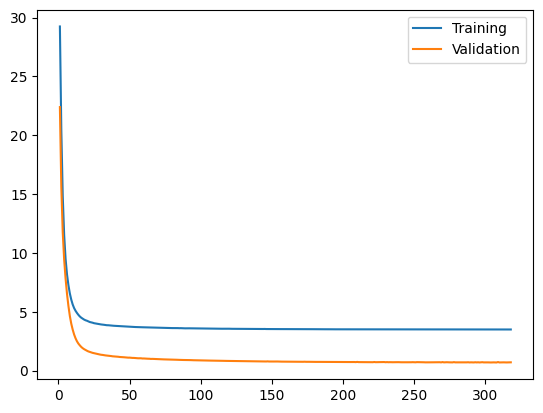

In [39]:
a = pipe4
history = a[-1].history
fig, ax = plt.subplots()
ax.plot(np.arange(1,len(history)+1),history[:, 'train_loss'],label="Training");
ax.plot(np.arange(1,len(history)+1),history[:, 'valid_loss'],label="Validation");
ax.legend();

0.371875

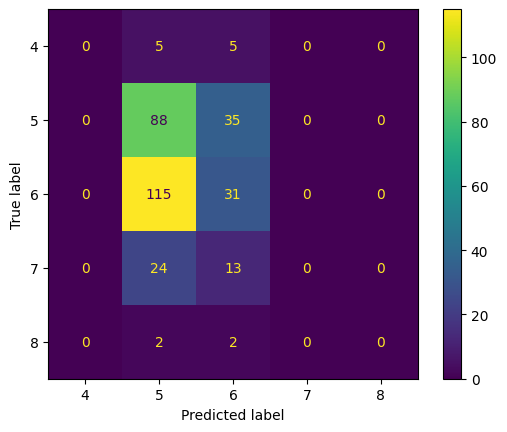

In [40]:
Y = pipe4.decision_function(x_red_test.values)
ConfusionMatrixDisplay.from_predictions(y_red_test,Y);
accuracy_score(y_red_test,Y)

### ANN Classifier for ordinal classification

In [5]:
from torch import nn, manual_seed, set_default_dtype, float64, device, cuda
from torch.optim import Adam
set_default_dtype(float64)
manual_seed(7)
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping
# Check for cuda 
device = device('cuda:0' if cuda.is_available() else 'cpu') 


In [6]:
class ModuleClassifier(nn.Module):
    def __init__(self, n_layers=2,layer_width=50,n_class=10,n_features=11):
        super(ModuleClassifier,self).__init__()
        self.layers = []
        self.acts = []
        self.layers.append(nn.Linear(n_features, layer_width))
        self.acts.append(nn.ReLU())
        for _ in range(n_layers):
            self.layers.append(nn.Linear(layer_width, layer_width))
            self.acts.append(nn.ReLU())
        self.output = nn.Linear(layer_width, n_class)
        self.softmax = nn.functional.softmax
    def forward(self, x):
        for layer, act in zip(self.layers, self.acts):
            x = act(layer(x))
        x = self.output(x)
        x = self.softmax(x,-1)
        return x

In [7]:
classifier_softmax = NeuralNetClassifier(
    ModuleClassifier,
    optimizer=Adam,
    max_epochs=150,
    criterion=nn.NLLLoss(),
    lr=0.001,
    iterator_train__shuffle=True,
    callbacks=[EarlyStopping,],
    callbacks__EarlyStopping__patience=5,
    batch_size=128,
)
pipe3 = Pipeline([("scaler",RobustScaler()),
                  ("data_augmentation",SMOTE(random_state=7)),
                 ("classifier",classifier_softmax),
                 ])

In [8]:
param_grid = {
   'data_augmentation' : Categorical(['passthrough',SMOTE(random_state=7,)]),
   'classifier__lr': Real(1e-6, 1e-1, prior='log-uniform'),
   'classifier__batch_size': Integer(16,256, prior="log-uniform",base=2),
   'classifier__module__n_layers': Integer(1,4),
   'classifier__module__layer_width': Integer(20,100),
   }

hiperparam_opt3_red = BayesSearchCV(
    pipe3,
    search_spaces=param_grid,
    random_state=7,
    
)

In [ ]:
hiperparam_opt3_red.fit(x_red_train,y_red_train)

In [10]:
hiperparam_opt3_red.best_params_

OrderedDict([('classifier__batch_size', 61),
             ('classifier__lr', 0.007017966647941806),
             ('classifier__module__layer_width', 100),
             ('classifier__module__n_layers', 1),
             ('data_augmentation', 'passthrough')])

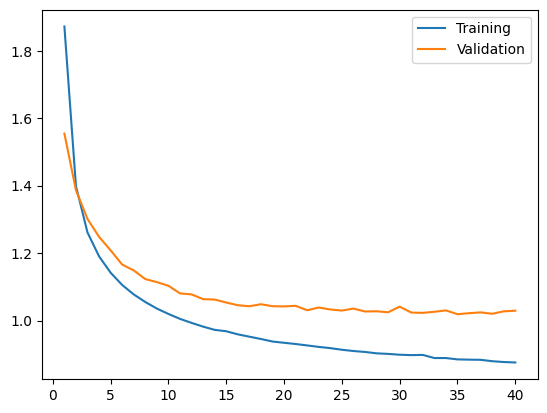

In [11]:
a = hiperparam_opt3_red.best_estimator_
history = a[-1].history
fig, ax = plt.subplots()
ax.plot(np.arange(1,len(history)+1),history[:, 'train_loss'],label="Training");
ax.plot(np.arange(1,len(history)+1),history[:, 'valid_loss'],label="Validation");
ax.legend();

/home/zarko/TCCM/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


0.615625

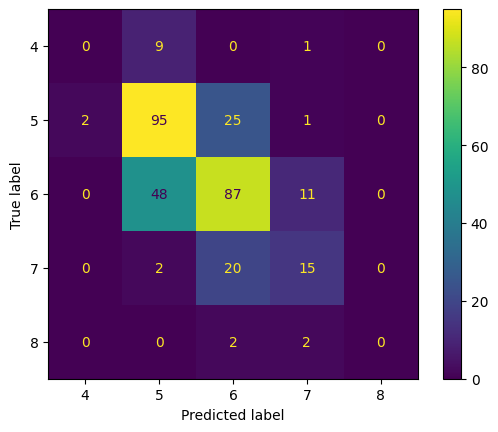

In [12]:
Y = hiperparam_opt3_red.predict(x_red_test.values)
ConfusionMatrixDisplay.from_predictions(y_red_test,Y);
accuracy_score(y_red_test,Y)

In [ ]:
param_grid_softmax = [
  {
   'data_augmentation' : Categorical(['passthrough',SMOTE(random_state=7,)]),
   },
 ]

In [ ]:
pipe_softmax = Pipeline([("scaler",RobustScaler()),
                 ("data_augmentation",SMOTE(random_state=7,)),
                 ("regressor",classifier_softmax),
                 ])
grid_search_softmax = BayesSearchCV(
    pipe_softmax, search_spaces=param_grid_softmax
)
grid_search_softmax.fit(x_red_train, y_red_train)

In [ ]:
Y = classifier_softmax.predict(x_red_test)
conf_matrix = confusion_matrix(y_red_test, Y,labels=[3,4,5,6,7,8])
ConfusionMatrixDisplay.from_predictions(y_red_test,Y,labels=[3,4,5,6,7,8])

In [ ]:
vID.end(cwd0)